In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pmlb as dsets
import numpy as np
import pickle as pkl
from os.path import join as oj
from copy import deepcopy
import pandas as pd

# sklearn models
sys.path.append('../scores')
import scores
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [2]:
data_dir = '/scratch/users/vision/data/pmlb'
out_dir = '/scratch/users/vision/chandan/pmlb'
dset_names = deepcopy(dsets.classification_dataset_names)
dset_names.remove('kddcup') # # remove biggest dset
dset_names.remove('mnist') # # remove biggest dset
dset_names.remove('poker') # # remove biggest dset

dset_names = np.array(dset_names)
random_state = 42 # for each train_test_split

# train models
this code will save all the **classification** dsets and fit very quick models to each of them

In [9]:
# logit_test_scores = []
# rf_test_scores = []
# rfs = []

# for dset_name in tqdm(dset_names):
#     X, y = dsets.fetch_data(dset_name, return_X_y=True, 
#                       local_cache_dir=data_dir)
    
    
#     train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=random_state)
    
#     logit = LogisticRegression(solver='liblinear', multi_class='auto') # liblinear best for small dsets, otherwise lbfgs
#     rf = RandomForestClassifier(n_estimators=100)
# #     print(dset_name, X.shape)
#     logit.fit(train_X, train_y)
#     rf.fit(train_X, train_y)
    
#     logit_test_scores.append(logit.score(test_X, test_y))
#     rf_test_scores.append(rf.score(test_X, test_y))
#     rfs.append(deepcopy(rf))
    
# # save
# logit_test_scores = np.array(logit_test_scores)
# rf_test_scores = np.array(rf_test_scores)
# classification_results = {'logit_test_score': logit_test_scores,
#            'rf_test_score': rf_test_scores,
#            'dset_name': dset_names,
#            'rf': rfs}
# pkl.dump(classification_results, 
#          open(oj(out_dir, 'classification_results.pkl'), 'wb'))

# analyze results

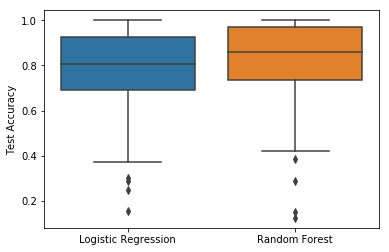

In [4]:
results = pd.DataFrame(pkl.load(open(oj(out_dir, 'classification_results.pkl'), 'rb')))

# plot
sns.boxplot(data=[results['logit_test_score'], results['rf_test_score']])
plt.xticks([0, 1], ['Logistic Regression', 'Random Forest'])
plt.ylabel('Test Accuracy')
plt.show()

# rank features
look at one dset

In [13]:
# get dsets where rf outperforms logistic
idxs_mask = results['rf_test_score'] - results['logit_test_score'] > 0.1 
r = results[idxs_mask]
print(results.shape, r.shape)
print('num idxs after filtering', np.sum(idxs_mask))
# idxs = np.arange(idxs_mask.size)[idxs_mask] # get actual indexes for this mask
row = r.iloc[0]

dset_name = row.dset_name # results['dset_names'][idx_0] #dsets.classification_dataset_names[0]
X, y = dsets.fetch_data(dset_name, return_X_y=True, 
                  local_cache_dir=data_dir)
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=random_state)
num_features = X.shape[1]
rf = row.rf
assert(rf.score(test_X, test_y) == row.rf_test_score) # check that acc matches

feature_scores = scores.get_importance_scores(rf, score_type='mda', X=test_X, Y=test_y)
feature_ranks = np.argsort(feature_scores)
print(f'feature_scores {feature_scores}\nfeature_ranks {feature_ranks}')

(163, 4) (39, 4)
num idxs after filtering 39
feature_scores [ 2.22044605e-17 -3.25000000e-03 -8.00000000e-03 -1.02500000e-02
 -4.25000000e-03  1.02500000e-02  1.32500000e-02 -1.00000000e-02
  2.12500000e-02  7.50000000e-04  2.50000000e-03  7.50000000e-04
  2.50000000e-04 -3.75000000e-03  1.75000000e-03  1.07500000e-02
  1.75000000e-03  2.22500000e-02  1.94750000e-01  1.64250000e-01]
feature_ranks [ 3  7  2  4 13  1  0 12  9 11 14 16 10  5 15  6  8 17 19 18]


In [25]:
import interactions
from scipy import interpolate

min 0 max 2


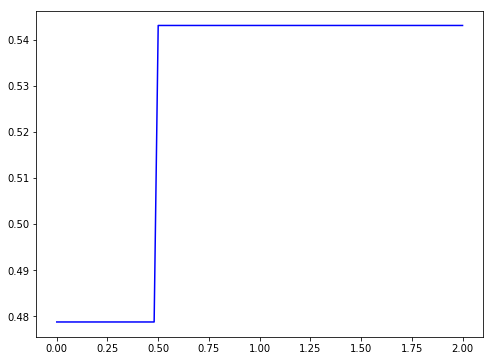

In [52]:
def get_feats(X, feat_nums=[0]):
    if len(feat_nums) == 1:
        return X[:, feat_num].reshape(-1, 1)
    else:
        return X[:, feat_num]

'''
arg1 - trained forest
arg2 - X
arg3 - y
arg4 - S (array of size num_features, 0 to not use this variable otherwise 1)

returns: value of function on a line at regular intervals
'''
def single_var_plot(forest, X, y, S, curve_range=None, step=None, plot=True):
    # deal with params
    if curve_range is None:
        curve_range = (np.min(X), np.max(X))
    step = (curve_range[1] - curve_range[0]) / 100
    curve_range = (curve_range[0], curve_range[1] + step) # do this so we can interpolate properly
    
    
    models = forest.estimators_
    length = (curve_range[1] - curve_range[0]) / (1.0 * step)
    line = np.zeros(int(length))
    index = np.nonzero(S)[0][0]
    num_vars = len(S)
    for model in models:
        vals = interactions.traverse_all_paths(model, X, y, S, continuous_y=True)
        line += interactions.make_line(vals, curve_range, step, S)
    line = line/(len(models) * 1.0)
    x_axis = np.arange(curve_range[0], curve_range[1], step)
    
    if plot:
        fig, ax = plt.subplots()
        fig.set_size_inches(8, 6, forward=True)
        plt.plot(x_axis, line, 'k', c='b')
        plt.show()
    return x_axis, line


feat_nums = [0]
feat_vals = get_feats(X, feat_nums)
feat_val_min = np.min(X)
feat_val_max = np.max(X)
print(f'min {feat_val_min} max {feat_val_max}')

# appropriate variable to get importance for
S = np.zeros(num_features)
S[feat_num]= 1

x_axis, scores_on_spaced_line = single_var_plot(rf, train_X, train_y, S, (feat_val_min, feat_val_max), step=0.1)
f = interpolate.interp1d(x_axis, scores_on_spaced_line, kind='nearest') # function to interpolate the scores

In [53]:
logit = LogisticRegression(solver='liblinear', multi_class='auto') # liblinear best for small dsets, otherwise lbfgs

# full training
print('full logit score', row.logit_test_score)

logit.fit(get_feats(train_X, feat_nums), train_y)
print('score orig var', logit.score(get_feats(test_X, feat_nums), test_y))
# logit.fit(train_X, train_y)
# rf.fit(train_X, train_y)
logit.fit(f(get_feats(train_X, feat_nums)), train_y)
print('score altered var', logit.score(get_feats(f(test_X), feat_nums), test_y))
# rf_test_scores.append(rf.score(test_X, test_y))

full logit score 0.5375
score orig var 0.47
score altered var 0.485
